In [1]:
import os 
import sys
import json
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import ast
sys.path.append('./models/')
from useful_functions import df_to_dict, concat_dico, get_classement, sort_list
from evaluate_model import WIS
from scipy.stats import gamma
from scipy.ndimage import uniform_filter1d

In [2]:
models1Dnames=['Moving Average','ARIMA', 'Exponential', 'Linear Regression', 'Bayesian Regression','SIRH1', 'SIRH2', 'SIRH3', 'SIRH4']
models3Dnames=[ 'VAR', 'Exponential Multi', 'SIRH Multi1', 'SIRH Multi2','SEIR Mob']
ens_names=['EnsAvg','EnsMedian','EnsRegr','EnsRMSE','EnsWIS','EnsRank']
reach='7'
alphas=np.array([0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
weights=np.concatenate((np.array([0.5]), alphas * 0.5))

list_of_models= models1Dnames+models3Dnames
print(list_of_models)

['Moving Average', 'ARIMA', 'Exponential', 'Linear Regression', 'Bayesian Regression', 'SIRH1', 'SIRH2', 'SIRH3', 'SIRH4', 'VAR', 'Exponential Multi', 'SIRH Multi1', 'SIRH Multi2', 'SEIR Mob']


In [3]:
#https://www.sciencedirect.com/science/article/pii/S2468042720300634
# Given parameters
mean = 4
std_dev = 3

# Calculate shape (k) and scale (theta) parameters
shape = (mean / std_dev) ** 2  # k (shape parameter)
scale = std_dev ** 2 / mean    # theta (scale parameter)

# Generate integer values to evaluate the PDF
x_values_int = np.arange(0, 21)  # Integer values from 0 to 20

# Compute the PDF at integer values
GT = gamma.pdf(x_values_int, a=shape, scale=scale)
GT = GT/np.sum(GT)

In [4]:
def safe_eval(x):
    replacement_value = [(0.0, 0.0)] * 11
    try:
        if isinstance(x, str):
            # Convert the string representation to an actual Python object
            evaluated = ast.literal_eval(x)

            # Check for (-inf, inf) tuples and replace with a default value (e.g., (0, 0))
            evaluated = [(0, 0) if (tup == (-np.inf, np.inf)) else tup for tup in evaluated]

            return evaluated
        else:
            return x
    except (ValueError, SyntaxError):
        return replacement_value  # Return None for invalid entries

In [5]:
def get_quantiles(w,row):
    q = [(0.0, 0.0)] * 11
    for i in range(len(list_of_models)):
        q = q + w[i]*np.array(row.iloc[i])
    return [tuple(row) for row in q]

In [6]:
def get_median_quantiles(row):
    q = np.zeros((11,2,len(list_of_models)))
    for i in range(len(list_of_models)):
        q[:,:,i] = np.array(row.iloc[i])
    mq=np.median(q,axis=2)
    return [tuple(row) for row in mq]

In [7]:
#def Lambda(t,ts,GT):
#    tmax=20
#    return np.sum(np.array([ts[t-i]*GT[i] for i in range(1,tmax)]))

In [8]:
#https://academic.oup.com/aje/article/178/9/1505/89262?login=true
#def est_R(t,ts, GT):
#    a=1
#    b=2
#    tau=7
#    n=a+np.sum(np.array([ts[i] for i in range(t-tau+1,t)]))
#    d=1/b+np.sum(np.array([Lambda(i,ts,GT) for i in range(t-tau+1,t)]))
#    return n/d

In [9]:
#https://academic.oup.com/aje/article/178/9/1505/89262?login=true
def est_R(incidence,GT):
    max_days=20
    gen_time_pmf=GT
    R_t = []
    for t in range(len(incidence)):
        if t == 0:  # Skip the first day (no prior data)
            R_t.append(np.nan)
            continue
        
        # Calculate the sum of weighted past incidences
        weighted_sum = 0
        for s in range(1, min(t + 1, max_days)):
            weighted_sum += gen_time_pmf[s] * incidence[t - s]
        
        if weighted_sum > 0:
            R_t.append(incidence[t] / weighted_sum)
        else:
            R_t.append(np.nan)

    return np.array(R_t)

In [10]:
def R_case(Rt):
    if Rt < 0.5:
        return 5
    elif Rt < 0.8:
        return 4
    elif Rt < 1.2:
        return 3
    elif Rt < 3:
        return 2
    else:
        return 1

In [12]:
#Load weights for Rank Ensemble
model_ranks=pd.read_csv('./ranks_for_ensemble_wis_7.csv')

In [17]:
name='_test_sweden.csv'
loss='WIS'
prediction=pd.read_csv('./results/predictions_of_the_models/countries/' + 'predictions_'+reach+'_days_on_pandemic' + name)
prediction.drop(['Unnamed: 0'], axis=1, inplace=True)
prediction.index=[20 * i for i in range(1, 15)]

quants=pd.read_csv('./results/predictions_of_the_models/countries/' + 'quantiles_'+reach+'_days_on_pandemic' + name)
quants=quants.applymap(safe_eval)
quants.drop(['Unnamed: 0'], axis=1, inplace=True)
quants.index=[20 * i for i in range(1, 15)]

pandemic = pd.read_csv('./all_pandemics/countries/pandemic'+name)
pandemic.drop(columns=['Unnamed: 0'],inplace=True)
n_hosp=np.array(pandemic.iloc[0])
n_inc=np.array(pandemic.iloc[1])

eval_name='evaluation_with_'+loss+'_of_1D_models_on_pandemic_test_sweden_and_reach_='+reach+'.json'
with open('./results/global_evaluation/countries/'+eval_name, 'r') as f:
    dicoresults1 = json.load(f)
with open('./results/global_evaluation/countries/'+eval_name.replace('1D', '3D'), 'r') as f:
    dicoresults2 = json.load(f)
dicoresults=concat_dico(dicoresults1, dicoresults2)
                

indexs_points=[[20*i] for i in range(1, 15) ]
real_values=np.array(prediction['Real values'])

#Load incidence data for Sweden
incidence=pd.read_excel('./all_pandemics/countries/acov19DAG_20250126-212219.xlsx')
inc=np.array(incidence.iloc[2,28:],dtype='float')
inc_real = uniform_filter1d(inc, size=7)

#Load death data for Sweden
deaths=pd.read_excel('./all_pandemics/countries/xcov19ivavDAG_20250128-075655.xlsx')
deaths=np.array(deaths.iloc[2,1:],dtype='float')
deaths = uniform_filter1d(deaths, size=7)
incs=68*deaths[13:]

Rt=est_R(incs,GT)

pred_ens_m=[]
wis_ens_m=[]
pred_ens_r=[]
wis_ens_r=[]

for i,point in enumerate(indexs_points):
    pred_ens2=np.median(prediction.iloc[i])
    quant_ens2=get_median_quantiles(quants.iloc[i])
    wis_ens2=WIS(real_values[i],quant_ens2,pred_ens2,alphas,weights)
    pred_ens_m.append(pred_ens2)
    wis_ens_m.append(wis_ens2)

    Rpoint=R_case(Rt[point[0]])
    print(Rt[point[0]],Rpoint, point[0])
    pred_ens6=np.dot(prediction.iloc[i,:-1],model_ranks.iloc[Rpoint,1:])
    quant_ens6=get_quantiles(model_ranks.iloc[Rpoint,1:],quants.iloc[i])
    wis_ens6=WIS(real_values[i],quant_ens6,pred_ens6,alphas,weights)
    pred_ens_r.append(pred_ens6)
    wis_ens_r.append(wis_ens6)

    

/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_58262/3326242937.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  quants=quants.applymap(safe_eval)
/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_58262/1508672954.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  q = q + w[i]*np.array(row.iloc[i])


1.44105458687418 2 20
0.9110838421113729 3 40
0.8426327128980314 3 60
0.9397073436263487 3 80
0.7975867528248939 4 100
0.7779328273643955 4 120
0.750074228513219 4 140
0.8459968990656932 3 160
1.188619584525326 3 180
1.2599273802796733 2 200
1.5848640550196977 2 220
1.2147004347204973 2 240
1.0735331022220664 3 260
1.0049340629164212 3 280


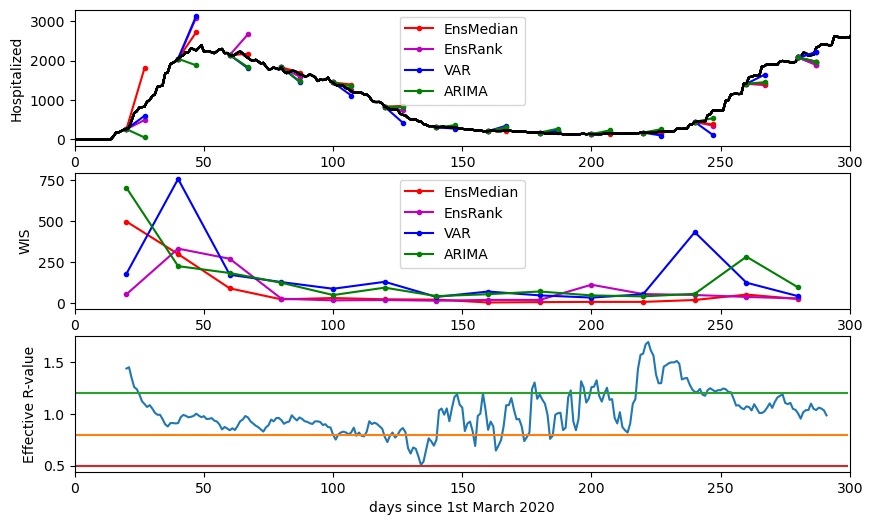

In [18]:
fig, axs = plt.subplots(3, figsize=(10,6))
for i in range(1,len(indexs_points)+1):
    x=[20*i,20*i+int(reach)]
    y_ens_r=[n_hosp[20*i],pred_ens_r[i-1]]
    y_ens_m=[n_hosp[20*i],pred_ens_m[i-1]]
    y_var=[n_hosp[20*i],prediction.iloc[i-1,9]]
    y_seir=[n_hosp[20*i],prediction.iloc[i-1,1]]
    
    axs[0].plot(x,y_ens_r,'m.-')
    axs[0].plot(x,y_ens_m,'r.-')
    axs[0].plot(x,y_var,'b.-')
    axs[0].plot(x,y_seir,'g.-')
    
    axs[0].plot(n_hosp,'k')

axs[0].plot(x,y_ens_m,'r.-',label='EnsMedian')
axs[0].plot(x,y_ens_r,'m.-',label='EnsRank')
axs[0].plot(x,y_var,'b.-',label='VAR')
axs[0].plot(x,y_seir,'g.-',label='ARIMA')
axs[0].set_xlim([0,300])

axs[0].set_xlabel('Days')
axs[0].set_ylabel('Hospitalized')    
axs[0].legend()

wis_var=[dicoresults[str(indexs_points[i])][9] for i in range(len(indexs_points))]
wis_seir=[dicoresults[str(indexs_points[i])][1] for i in range(len(indexs_points))]
axs[1].plot(indexs_points,wis_ens_m,'r.-',label='EnsMedian')
axs[1].plot(indexs_points,wis_ens_r,'m.-',label='EnsRank')
axs[1].plot(indexs_points,wis_var,'b.-',label='VAR')
axs[1].plot(indexs_points,wis_seir,'g.-',label='ARIMA')
axs[1].set_xlim([0,300])
#axs[1].set_ylim([0,500])

axs[1].set_xlabel('days since 1st March 2020')
axs[1].set_ylabel('WIS')    
axs[1].legend()

axs[2].plot(np.arange(20,len(Rt)),Rt[20:]) #20
axs[2].plot(np.arange(0,300),0.8*np.ones(300))
axs[2].plot(np.arange(0,300),1.2*np.ones(300))
axs[2].plot(np.arange(0,300),0.5*np.ones(300))

axs[2].set_xlim([0,300])
axs[2].set_xlabel('days since 1st March 2020')
axs[2].set_ylabel('Effective R-value')

fig.savefig('sweden.pdf')

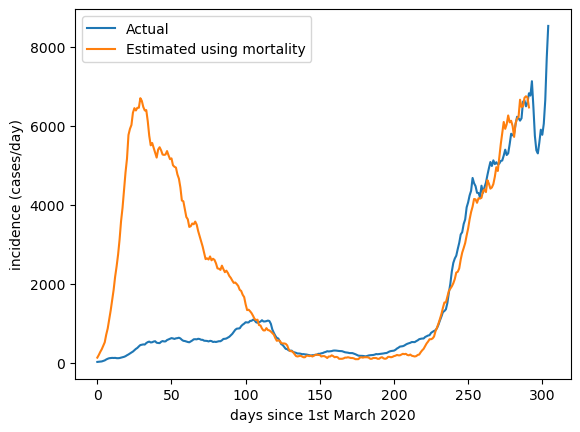

In [19]:
#Comparing estimated and actual incidence
plt.plot(inc_real,label='Actual')
plt.plot(incs,label='Estimated using mortality')
plt.xlabel('days since 1st March 2020')
plt.ylabel('incidence (cases/day)')
plt.legend()
fig.savefig('sweden_incidence.pdf')